# Executive summary

This the purpose of this project is to determine what factors contribute most to sales for a national quick service restaurant and how we, as a digital marketing firm, can use those factors to more efficiently determine where we should focus a campaign. Specifically, we will examine what factors increase online sales as measured by conversions. Conversions are when an online sale is made through an advertizement. 

Many factors have been linked to sales, but the interaction of these factors has not been determined. The goal of this study is to determine the relationship between several of these factors in order to maximize return on ad spend. Weather is an important factor in the online sales of this company as there are much greater sales during winter months. There are also sales spikes around holidays, the end of the week, and big sporting events(mainly football). If we can show which combination of these factors predict high sales, we can use different thresholds of these factors to determine where we want to be spending our advertising dollar.  

Through looking at past data, we can determine what the most important predictors of higher than normal online sales might be. We will use an ensemble decision tree method called random forest in order to both predict values for online sales as well as classifying whether a day will be a low, medium low, medium high, or high conversion day. If we know that a day might be a high conversion day anyways, we could spend less money on those days, and focus resources on days where there is more potential to increase conversions.

We used 2014 and 2015 data to see if we could produce a good model of one year based on the last years data. If the 2014 is a good predictor of the conversions in 2015, we can apply this model to determine our targeted ad spend in 2016. The random forest models we have used are very good at classifying days as mentioned above and will provide a good basis for what type day we think we will see. 

We saw some inconsistencies in the 2015 data, which a had much lower conversion average (50% lower) and much lower maximum values. We therefore focused on using the 2014 data to build the strongest model we could. To do this we hid the actual conversion values for 2014 from the model and asked it to predict the number of conversions.  We were able to produce a model that predicted values that were very correlated to the known actual values for those days. However, there was a lot of variation in the predictions, meaning that there were sometimes predicted spikes when there were none in the actual data and vice versa. We decided to take another approach that would give us actionable data without worrying about incorrect spikes in conversions.

We broke the conversions up into high, high medium, low medium and low conversion days base on quartiles of the data. we then asked the model to again place the different days into these categories without knowing the class the actual conversions belonged in. This model was far more successful and produced actionable predictions. This model correctly predicts high sales days more than 90% of the time. It also exceeded at predicting the other categories of conversions. We can continue to use this model to more efficiently use our ad spend to maximize return. We can avoid spending too much on days we would have high conversions regardless and focus on boosting conversions on days where we would predict lower conversions. 



# Technical Review and Code

### EDA and data cleaning
The football games that are included in the analysis are all NFL games (including playoffs) and college football games that involve a top 25 ranked team. This data was queried and downloaded as a csv from sportsreference.com. Weather data was gathered through a query on the NOAA website, which included data from 3 weather stations covering the metro Atlanta area, giving a good overview of the weather trends. All data was gathered by date, so it will be easy to join dataframes and be confident in the data being concurrent.

In [299]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.cross_validation import KFold,cross_val_score,train_test_split,cross_val_predict
from sklearn.preprocessing import MinMaxScaler, label_binarize, LabelEncoder
from sklearn.metrics import r2_score,classification_report,roc_curve,auc,accuracy_score,precision_score,recall_score
from sklearn.grid_search import GridSearchCV
from sklearn.tree import export_graphviz
from sklearn.metrics import precision_recall_fscore_support as score
from scipy import interp
import scipy
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt
import sqlalchemy

%matplotlib inline

In [300]:
#importing nfl 2014 schedule and results data set, downloaded from sportsreference.com
nfl14 = pd.read_csv('../Assets/nfl2014schedule.csv') 
nfl14['Date'] = '2014 ' + nfl14['Date']

In [301]:
#importing nfl 2015 schedule and results data set, downloaded from sportsreference.com

nfl15 = pd.read_csv('../Assets/nfl2015schedule.csv') 
nfl15['Date'] = '2015 ' + nfl15['Date']

In [302]:
#joining the dataframes
nflSched = pd.concat([nfl14,nfl15])

In [303]:
#Dropping columns that won't help predict sales
nflSched.drop(['Week','Day','Unnamed: 4','Unnamed: 6','PtsW','PtsL','YdsW','TOW','YdsL','TOL'], axis=1, inplace=True)

In [304]:
#eliminating strings that were found in empty rows in the dataframe
nflSched = nflSched[nflSched['Date']!= '2014 Date']
nflSched = nflSched[nflSched['Date']!= '2014 Playoffs']
nflSched = nflSched[nflSched['Date']!= '2015 Date']
nflSched = nflSched[nflSched['Date']!= '2015 Playoffs']

In [305]:
#converting to datetime and setting as index
nflSched['Date'] = pd.to_datetime(nflSched['Date'], format='%Y %B %d')
nflSched.set_index('Date', inplace=True)

In [306]:
#adding a column so that we will have a column that indicates dates that have an NFL game
nflSched['NflGame'] = 1

In [307]:
#importing college football 2014 and 2015 schedule and results data set, downloaded from sportsreference.com
cfb14 = pd.read_csv('../Assets/cfb2014schedule.csv') 
cfb15 = pd.read_csv('../Assets/cfb2015schedule.csv')     

In [308]:
#combining the dataframes
cfbSched = pd.concat([cfb14,cfb15])

In [309]:
#dropping columns that I don't think will be good predictors
cfbSched.drop(['Rk','Wk','Time','Day','Pts','Unnamed: 7','Pts.1','Notes'], axis=1, inplace=True)

In [310]:
#removing columns that just contain the string 'Date'
cfbSched = cfbSched[cfbSched['Date']!= 'Date']

In [311]:
#converting to datetime and setting as index
cfbSched['Date'] = pd.to_datetime(cfbSched['Date'], format='%b %d %Y')
cfbSched.set_index('Date', inplace=True)

In [312]:
#adding a column so that we will have a column that indicates dates that have an cfb game
cfbSched['cfbGame'] = 1

In [313]:
#making better column names to see if network, or teams involved influence sales
cfbSched=cfbSched.rename(columns = {'Winner/Tie':'CfbWinner', 'Loser/Tie':'CfbLoser', 'TV':'CfbTV'})

In [314]:
#importing weather data from the noaa
Weather = pd.read_csv('../Assets/AtlWeather.csv') 

In [315]:
#converting to datetime
Weather['DATE'] = pd.to_datetime(Weather['DATE'], format='%Y%m%d')

In [316]:
#dropping columns we don't need, and eliminating null value place holders
Weather.drop([u'STATION',u'STATION_NAME',u'MDPR',u'DAPR',u'SNWD',u'TOBS',u'WESD'
             , u'WESF', u'WT01', u'WT06', u'WT02', u'WT04', u'WT08', u'WT03','PSUN','TAVG','SNOW','TSUN'], axis=1, inplace=True)

Weather.replace('-9999',np.nan, inplace=True)
Weather.replace('-9999.0',np.nan, inplace=True)

In [317]:
Weather.rename(columns = {'DATE':'Date'}, inplace=True)
Weather.set_index('Date', inplace=True)

In [318]:
#There are many weather stations across the Atlanta area, so we are taking the mean of these stations to estimate weather for
#the metro area
Weather = Weather.groupby(Weather.index).mean()

In [319]:
Final = pd.merge(Weather, cfbSched, left_index=True, right_index=True, how='outer')
Final = pd.merge(Final, nflSched, left_index=True, right_index=True, how='outer')

In [320]:
#slicing the dataframe to include the pro and college football seasons from 2014 to 2016 for a master table
Final = Final.ix['2014-8':'2016-03']

In [321]:
#importing client data for Atlanta area 
columns=['Date','PSA Sales','Orders','Online Sls %', 'Carryout %', 'Rewards Enrollment']
conv = pd.read_csv('../Assets/AtlantaSales2014_2016.csv', names=columns, header=0) 

In [322]:
conv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
Date                  961 non-null object
PSA Sales             961 non-null float64
Orders                961 non-null int64
Online Sls %          961 non-null object
Carryout %            961 non-null object
Rewards Enrollment    961 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 45.1+ KB


In [323]:
conv.head()

,Date,PSA Sales,Orders,Online Sls %,Carryout %,Rewards Enrollment
0,2013-12-30,2479.445385,14552,51.23323563,40.18691589,453720
1,2013-12-31,4257.727404,23195,46.86579255,45.30717827,454383
2,2014-01-01,3056.406058,17538,54.60225831,36.57771696,455046
3,2014-01-02,2864.802308,16538,49.81327413,38.24525336,455616
4,2014-01-03,4387.694135,24525,49.22157619,40.39551478,456442


In [324]:
conv['Date'] = pd.to_datetime(conv['Date'], format='%Y-%m-%d')

In [325]:
conv.set_index('Date', inplace=True)

In [326]:
conv.head()

,PSA Sales,Orders,Online Sls %,Carryout %,Rewards Enrollment
Date,,,,,
2013-12-30,2479.445385,14552,51.23323563,40.18691589,453720
2013-12-31,4257.727404,23195,46.86579255,45.30717827,454383
2014-01-01,3056.406058,17538,54.60225831,36.57771696,455046
2014-01-02,2864.802308,16538,49.81327413,38.24525336,455616
2014-01-03,4387.694135,24525,49.22157619,40.39551478,456442


In [327]:
for i in conv.columns:
    if conv[i].dtype == object:
        conv[i] = conv[i].convert_objects(convert_numeric=True)

conv.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 961 entries, 2013-12-30 to 2016-08-16
Data columns (total 5 columns):
PSA Sales             961 non-null float64
Orders                961 non-null int64
Online Sls %          959 non-null float64
Carryout %            960 non-null float64
Rewards Enrollment    958 non-null float64
dtypes: float64(4), int64(1)
memory usage: 45.0 KB


/Users/AlexStrahan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  app.launch_new_instance()


In [328]:
conv.rename(columns = {'PSA Sales':'psa_sales','Online Sls %':'Online%','Carryout %':'carryout%',
                         'Papa Rewards Customer Enrollments':'rewards'}, inplace=True)

In [329]:
conv['online_sales'] = conv['psa_sales'] * (conv['Online%']/100)

In [330]:
conv.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 961 entries, 2013-12-30 to 2016-08-16
Data columns (total 6 columns):
psa_sales             961 non-null float64
Orders                961 non-null int64
Online%               959 non-null float64
carryout%             960 non-null float64
Rewards Enrollment    958 non-null float64
online_sales          959 non-null float64
dtypes: float64(5), int64(1)
memory usage: 52.6 KB


In [331]:
conv.head()

,psa_sales,Orders,Online%,carryout%,Rewards Enrollment,online_sales
Date,,,,,,
2013-12-30,2479.445385,14552,51.233236,40.186916,453720.0,1270.300096
2013-12-31,4257.727404,23195,46.865793,45.307178,454383.0,1995.417693
2014-01-01,3056.406058,17538,54.602258,36.577717,455046.0,1668.866731
2014-01-02,2864.802308,16538,49.813274,38.245253,455616.0,1427.051827
2014-01-03,4387.694135,24525,49.221576,40.395515,456442.0,2159.692212


In [332]:
#merging the dataframe with the final dataframe
Final = pd.merge(Final, conv, left_index=True, right_index=True, how='outer')


In [333]:
#slicing the dataframe to include the pro and college football seasons from 2014 to 2015 so that we can look at the 
#seasons separately 
Final2 = Final.ix['2014-8':'2015-3']
Test = pd.DataFrame()
Test = Final.ix['2015-8':'2016-3']

In [334]:
#replacin NaN's with zeros so that we can identify whether there was or was not a football game 
Final2['cfbGame'].replace('NaN', 0.0,inplace=True)
Final2['NflGame'].replace('NaN', 0.0, inplace=True)

Test['cfbGame'].replace('NaN', 0.0,inplace=True)
Test['NflGame'].replace('NaN', 0.0, inplace=True)
#1=game on that day, 0=no game

In [335]:
Final2['Day']=Final2.index.weekday
Test['Day']=Test.index.weekday

/Users/AlexStrahan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/AlexStrahan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [336]:
# #establishing connection to SQL database, dumping final table into database
# user = "postgres:Lumberjack1"
# engine = sqlalchemy.create_engine('postgresql://{}{}'.format(user,'@localhost:5432/Rforest'))
# Final.to_sql("final", con = engine, if_exists="replace")


In [337]:
# EDA
# Final2.corr()


In [338]:
#Final2.drop('CfbWinner','CfbLoser','CfbTV','Winner/tie','Loser/tie')
Final2.head(50)

,PRCP,TMAX,TMIN,CfbWinner,CfbLoser,CfbTV,cfbGame,Winner/tie,Loser/tie,NflGame,psa_sales,Orders,Online%,carryout%,Rewards Enrollment,online_sales,Day
Date,,,,,,,,,,,,,,,,,
2014-08-01,0.590833,81.666667,66.666667,NaN,NaN,NaN,0.0,NaN,NaN,0.0,4520.945238,23789,47.864914,40.922275,548807.0,2163.946571,4
2014-08-02,0.010952,84.333333,66.666667,NaN,NaN,NaN,0.0,NaN,NaN,0.0,3861.717524,20345,47.075328,40.324404,549375.0,1817.916190,5
2014-08-03,0.000476,88.333333,66.666667,NaN,NaN,NaN,0.0,NaN,NaN,0.0,2764.286286,14971,49.429905,39.609913,549779.0,1366.384095,6
2014-08-04,0.000000,89.666667,68.333333,NaN,NaN,NaN,0.0,NaN,NaN,0.0,2017.781333,11679,48.235927,40.166110,550040.0,973.295524,0
2014-08-05,0.000000,89.333333,67.333333,NaN,NaN,NaN,0.0,NaN,NaN,0.0,2333.177524,14855,47.926217,50.420734,550426.0,1118.203714,1
2014-08-06,0.000000,91.666667,65.000000,NaN,NaN,NaN,0.0,NaN,NaN,0.0,2348.213048,13401,48.617155,41.870010,550799.0,1141.634381,2
2014-08-07,0.020370,94.666667,69.333333,NaN,NaN,NaN,0.0,NaN,NaN,0.0,2604.384952,14569,49.483604,40.627359,551207.0,1288.743524,3
2014-08-08,0.868966,89.000000,69.666667,NaN,NaN,NaN,0.0,NaN,NaN,0.0,4972.862857,26401,52.994050,40.403773,552010.0,2635.321428,4
2014-08-09,1.504483,89.333333,69.666667,NaN,NaN,NaN,0.0,NaN,NaN,0.0,4393.658667,24077,52.488771,40.196038,552816.0,2306.177429,5


## Data Dictionary

|Column Name|Data|
|-----------|----|
|PRCP| The amount of precipitation that day in inches|
|TMAX| The maximum measured temperature for the day in degrees Farenheit|
|TMIN| The minimum measured temperature for the day in degrees Farenheit|
|CfbWinner| The team that won the college football game on that day|
|CfbLoser| The team that lost the college football game on that day|
|CfbTV| Television network a college football game was broadcast on|
|cfbGame| Whether there was a college football game on that day|
|Winner/tie| The team that won the NFL game on that day|
|Loser/tie| The team that lost the NFL game on that day|
|NflGame| Whether there was an NFL game on that day|
|psa_sales| per store average sales|
|Orders| transaction volume for Atlanta market|
|online%| percentage of per store average sales that were made online|
|carryout%| percentage of orders that were carryout|
|rewards| Number of rewards program members|
|online_sales| psa_sales multiplied by percentage of online sales|
|Day| day of the week represented by integers 0-6 with 0 being Monday|

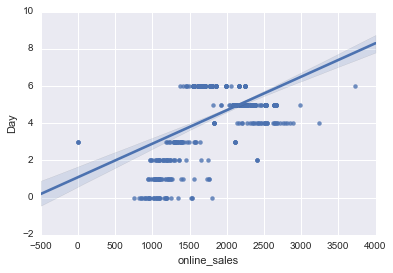

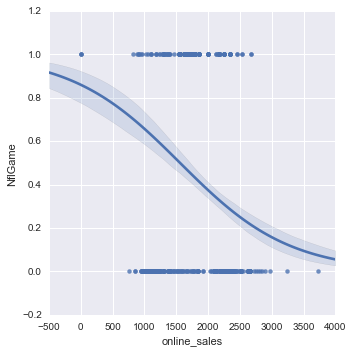

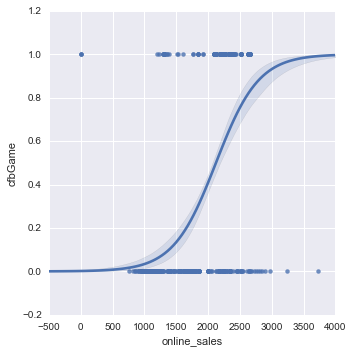

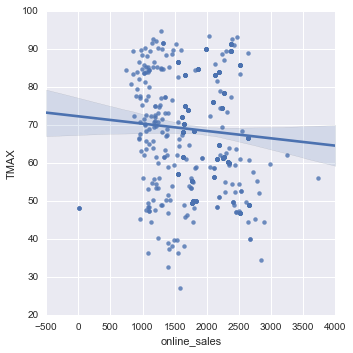

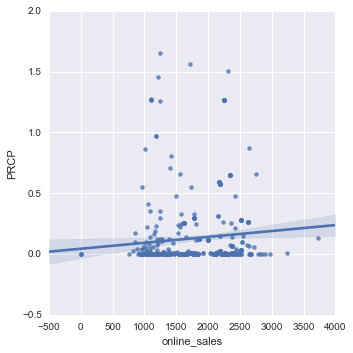

In [339]:
plt.figure(1)
plt.subplot(1, 1, 1)
sns.regplot('online_sales','Day', Final2)

plt.figure(2)
sns.lmplot('online_sales','NflGame',Final2, logistic=True)

plt.figure(3)
sns.lmplot('online_sales','cfbGame', Final2, logistic=True)

plt.figure(4)
sns.lmplot('online_sales','TMAX', Final2)

plt.figure(5)
sns.lmplot(x='online_sales',y='PRCP',data=Final2)

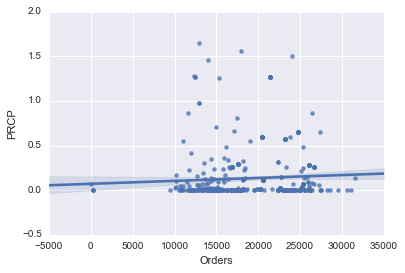

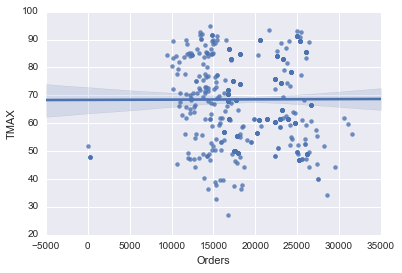

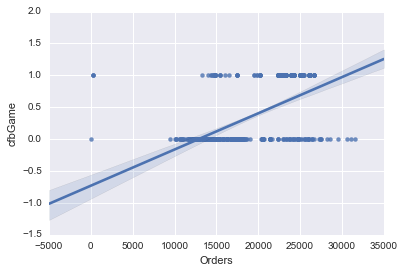

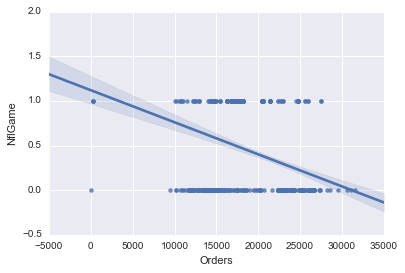

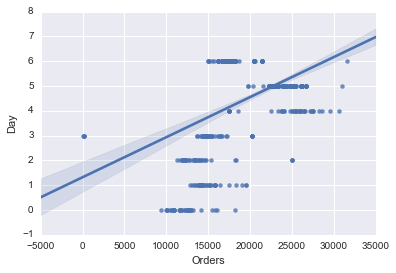

In [340]:
# EDA

plt.figure(1)
plt.subplot(1, 1, 1)
sns.regplot(Final2['Orders'],Final2['PRCP'])

plt.figure(2)
plt.subplot(1, 1, 1)
sns.regplot(Final2['Orders'],Final2['TMAX'])

plt.figure(3)
plt.subplot(1, 1, 1)
sns.regplot(Final2['Orders'],Final2['cfbGame'])

plt.figure(4)
plt.subplot(1, 1, 1)
sns.regplot(Final2['Orders'],Final2['NflGame'])

plt.figure(5)
plt.subplot(1, 1, 1)
sns.regplot(Final2['Orders'],Final2['Day'])


In [341]:
Final2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 704 entries, 2014-08-01 to 2015-03-31
Data columns (total 17 columns):
PRCP                  704 non-null float64
TMAX                  704 non-null float64
TMIN                  704 non-null float64
CfbWinner             281 non-null object
CfbLoser              281 non-null object
CfbTV                 277 non-null object
cfbGame               704 non-null float64
Winner/tie            285 non-null object
Loser/tie             285 non-null object
NflGame               704 non-null float64
psa_sales             704 non-null float64
Orders                704 non-null int64
Online%               703 non-null float64
carryout%             703 non-null float64
Rewards Enrollment    703 non-null float64
online_sales          703 non-null float64
Day                   704 non-null int32
dtypes: float64(10), int32(1), int64(1), object(5)
memory usage: 96.2+ KB


In [342]:
#Using category codes for columns with many categorical variables (winners/losers of games, tv network, etc)
for i in Final2.columns:
    if Final2[i].dtype == object:
        Final2[i] = Final2[i].astype('category')
        Final2[i] = Final2[i].cat.codes
    

/Users/AlexStrahan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/AlexStrahan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [343]:
for i in Test.columns:
    if Test[i].dtype == object:
        Test[i] = Test[i].astype('category')
        Test[i] = Test[i].cat.codes

/Users/AlexStrahan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/AlexStrahan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [344]:
Final2.dropna(inplace=True)
print Final2.shape

Test.dropna(inplace=True)
print Test.shape

(702, 17)
(577, 17)


/Users/AlexStrahan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/AlexStrahan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [345]:
#creating target and predictors for 2014 data to see if these are good predictors for conversions before I use 2014 data 
#to try to predict 2015 data
y=Final2['online_sales']
X=Final2.drop(Final2.ix[:,10:], axis=1)
X['Day']=Final2['Day']

In [347]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=20)

In [349]:
#fitting a decision tree model using cross validation
cv = KFold(len(y_train), shuffle=False) 
print cv
dt = DecisionTreeRegressor(random_state=5)
dtScore = cross_val_score(dt, X_train, y_train, cv=cv,n_jobs=1)
print "Regular Decision Tree scores are:", dtScore
print "Regular Decision Tree average score is:", dtScore.mean()

sklearn.cross_validation.KFold(n=491, n_folds=3, shuffle=False, random_state=None)
Regular Decision Tree scores are: [ 0.6739098   0.797494    0.84877447]
Regular Decision Tree average score is: 0.773392754931


In [350]:
#fitting a random forest model using cross validation and comparing it to previous model

rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=1, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=5,
           verbose=0, warm_start=False)
rfScore = cross_val_score(rf, X_train,y_train, cv=cv, n_jobs=1)
print "Random Forest scores are:", rfScore
print "Regular Decision Tree scores are:", dtScore
print "Random Forest average score is:", rfScore.mean()
print "Regular Decision Tree average score is:", dtScore.mean()

Random Forest scores are: [ 0.82248011  0.8282232   0.8824613 ]
Regular Decision Tree scores are: [ 0.6739098   0.797494    0.84877447]
Random Forest average score is: 0.844388203889
Regular Decision Tree average score is: 0.773392754931


In [351]:
# rfc = RandomForestRegressor(n_jobs=-1, max_features= 'sqrt' ,n_estimators=100) 

# param_grid = { 
#     'n_estimators': [100,200,300,400,500],
#     'max_features': [None, 'sqrt', 'log2'],
#     'min_samples_split':[1,2,3,4,5,6]
# }

# CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
# CV_rfc.fit(X_train, y_train)
# print CV_rfc.best_params_
# print CV_rfc.best_estimator_

In [352]:
#fitting a adaboost model using cross validation and comparing it to previous model

ab = AdaBoostRegressor(base_estimator=None, learning_rate=2.0, loss='linear',
         n_estimators=300, random_state=5)
abScore = cross_val_score(ab, X_train,y_train, cv=cv, n_jobs=1)
print "Adaptive Boost scores are :",abScore
print "Random Forest scores are:", rfScore
print "Regular Decision Tree scores are:", dtScore
print "Adaptive Boost average score is:",abScore.mean()
print "Random Forest average score is:", rfScore.mean()
print "Regular Decision Tree average score is:", dtScore.mean()

Adaptive Boost scores are : [ 0.73703259  0.71449479  0.80272391]
Random Forest scores are: [ 0.82248011  0.8282232   0.8824613 ]
Regular Decision Tree scores are: [ 0.6739098   0.797494    0.84877447]
Adaptive Boost average score is: 0.751417096067
Random Forest average score is: 0.844388203889
Regular Decision Tree average score is: 0.773392754931


In [353]:
#Grid search for best parameters
# abc = AdaBoostRegressor() 

# param_grid2 = { 
#     'n_estimators': [50,100,150,200],
#     'learning_rate': [1.0,2.0,3.0,4.0]
# }

# CV_abc= GridSearchCV(estimator=abc, param_grid=param_grid2, cv= 5)
# CV_abc.fit(X_train, y_train)
# print CV_abc.best_params_
# print CV_abc.best_estimator_

In [354]:
#plotting cross-validated models
def do_plot(model, m=None):
    for fold, color in zip(cv, ['r','g','b']):#colors are from different folds from Kfold, so 3 diff models
        
        X_train = X.iloc[fold[0]]
        X_test =  X.iloc[fold[1]]
        y_train = y.iloc[fold[0]]
        y_test = y.iloc[fold[1]]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        plt.scatter(y_test, y_pred, color=color)
        plt.plot([0,3500],[0,3500])
        plt.text(2500,0, "R2:"+str(m), fontsize=20, )
        plt.xlabel('Actual Conversions')
        plt.ylabel('Predicted Conversions')

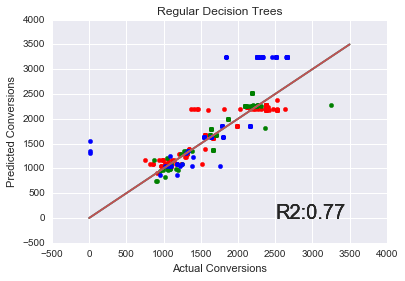

In [355]:
do_plot(dt, dtScore.mean().round(2))
plt.title("Regular Decision Trees")

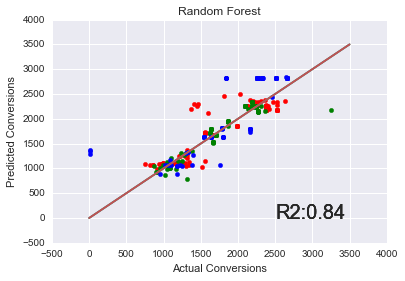

In [356]:
do_plot(rf, rfScore.mean().round(2))
plt.title("Random Forest")

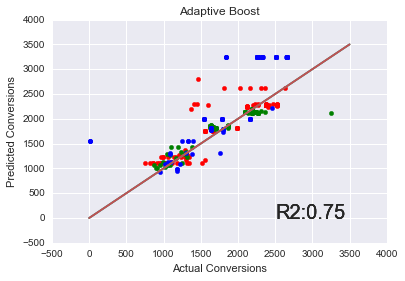

In [357]:
do_plot(ab, abScore.mean().round(2))
plt.title("Adaptive Boost")

In [358]:
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=1, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=5,
           verbose=0, warm_start=False)

In [359]:
ab.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=2.0, loss='linear',
         n_estimators=300, random_state=5)

In [360]:
#calculating feature importance for random forest
all(rf.feature_importances_ == np.mean([tree.feature_importances_ for tree in rf.estimators_], axis=0))

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
feature_names = X_train.columns

(array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8]),
 <a list of 10 Text yticklabel objects>)

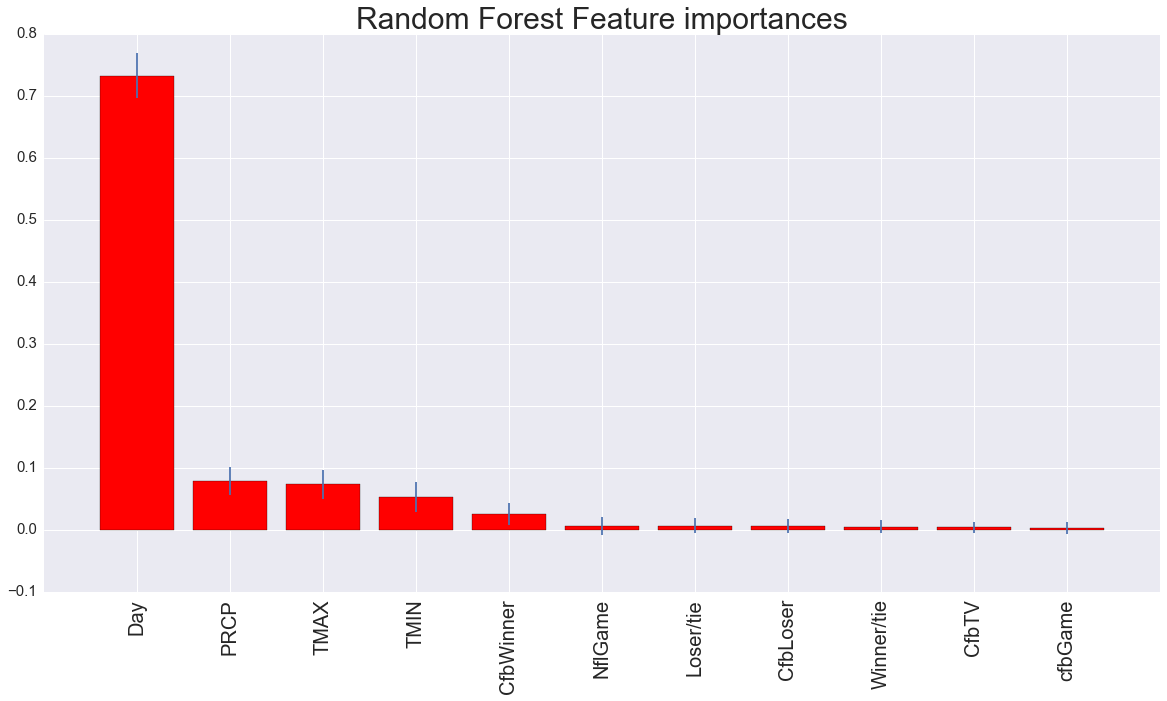

In [361]:
plt.figure(figsize=(20,10))
plt.title("Random Forest Feature importances", fontsize = 30)
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90, fontsize = 20)
plt.xlim([-1, X_train.shape[1]])
plt.yticks(fontsize=15)

In [362]:
#calculating feature importance for Adaboost
all(ab.feature_importances_ == np.mean([tree.feature_importances_ for tree in ab.estimators_], axis=0))

importances2 = ab.feature_importances_
std2 = np.std([tree.feature_importances_ for tree in ab.estimators_], axis=0)
indices2 = np.argsort(importances)[::-1]
feature_names2 = X_train.columns

(array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7]),
 <a list of 9 Text yticklabel objects>)

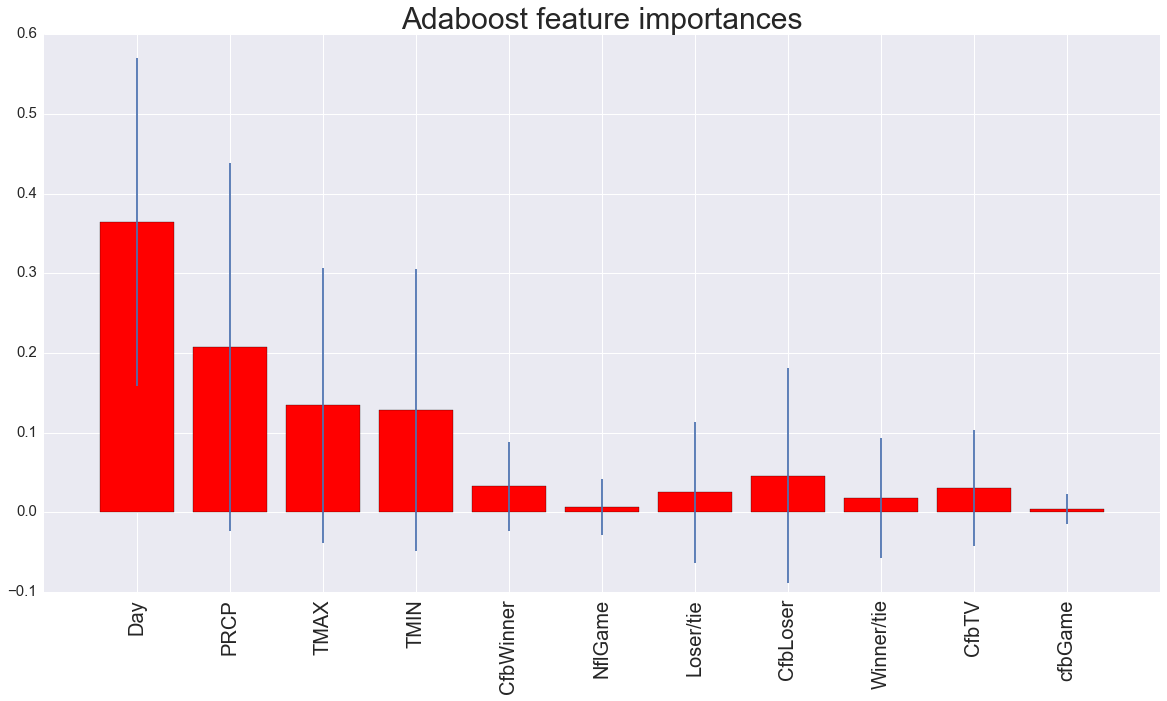

In [363]:
plt.figure(figsize=(20,10))
plt.title("Adaboost feature importances", fontsize = 30)
plt.bar(range(X_train.shape[1]), importances2[indices],
       color="r", yerr=std2[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names2[indices], rotation=90, fontsize = 20)
plt.xlim([-1, X_train.shape[1]])
plt.yticks(fontsize=15)

We can see in both the adaptive boost model and the randome forest model, weather and day of the week seem to be more important features for splitting the data and sporting events are less important. This could lead to better targeting of ads, where the conversions will happen regardless of whether there is a sports game on, but we can increase ads on days where the weather is not indicative of great sales in order to increase sales on those days. 

In [364]:
#random forest predictions
rfy_pred = rf.predict(X_test)
rfpredictions = pd.DataFrame()
rfpredictions['actual'] = y_test
rfpredictions['predict'] = rfy_pred

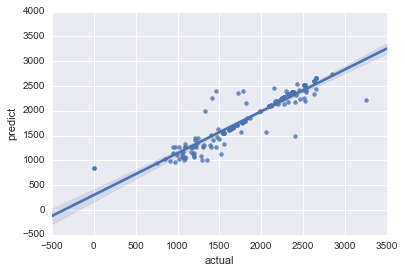

In [365]:
#test train split of model on 2014 data
sns.regplot(rfpredictions['actual'],rfpredictions['predict'])

In [366]:
r2_score(rfpredictions['actual'],rfpredictions['predict'])

0.86265118567452759

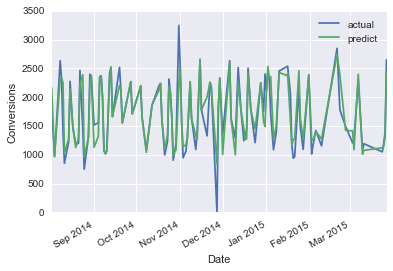

In [367]:
rfpredictions.plot()
plt.ylabel('Conversions')

In [368]:
rfpredictions.describe()

,actual,predict
count,211.000000,211.000000
mean,1860.640842,1872.206631
std,540.598387,490.756096
min,6.087358,842.179793
25%,1507.062853,1548.930175
50%,1800.169434,1862.744190
75%,2283.866391,2270.978937
max,3245.653962,2746.711726


We have used several different models to see which one performs the best on this split data. The random forest performed best and was applied to the 2014 data to produce predictions. The model has a good r2_score at 0.86, but we can see from the plot of the predicted vs. actual values that there is a lot of variation away from the known values, with some big predicted spikes where there are none in the real data. For this reason we will later perform a random forest classifier to try to bin the conversions and make for less variation in the predicted classes as a result.

In [369]:
# now fit model to all of 2014 data and predict 2015 data

In [370]:
Conv2015 = pd.DataFrame()
Conv2015['actual'] = Test['online_sales']
Features15 = Test.drop(Test.ix[:,10:], axis=1)
X2=Final2.drop(Final2.ix[:,10:], axis=1)
y2=Final2['online_sales']
X2['Day']=Final2['Day']
Features15['Day']=Test['Day']

In [371]:
#Fitting model to all of the 2014 data
rf.fit(X2,y2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=1, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=5,
           verbose=0, warm_start=False)

In [372]:
pred15 = rf.predict(Features15)
Conv2015['predicted'] = pred15

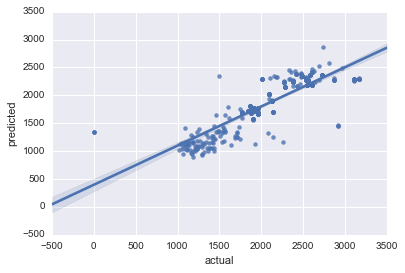

In [373]:
sns.regplot(Conv2015['actual'],Conv2015['predicted'])

In [374]:
r2_score(Conv2015['actual'],Conv2015['predicted'])

0.54872947194930166

This regression model for 2015 data is not very good. The r2_score is around 0.5, which means that we have a positive correlation, but not a very strong one.  This is perhaps a situation where a classification model may be a better fit.

In [375]:
Conv2015.describe()

,actual,predicted
count,577.000000,577.000000
mean,2138.642120,1897.460958
std,528.492526,424.708928
min,4.163271,889.353347
25%,1874.707383,1682.137388
50%,2123.181495,1902.950280
75%,2555.501402,2282.689369
max,3163.251402,2861.274253


(0, 3500)

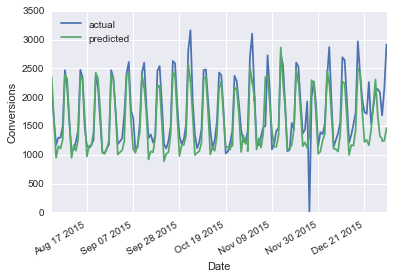

In [376]:
Conv2015.plot()
plt.ylabel('Conversions')
plt.ylim(0, 3500)


The Adapdtive boost and the regular decision tree regression models did not do as well as a random forest at predicting online sales in a given day after being trained on the split data for 2014 (70% train, 30% test). The r^2 for the Adaboost and the regular decision tree were greater then 0.10 less than the random forest, which did much better. 

The random forest regression model was good at predicting within year, but not very good at using results from one year to predict another. The r^2 for the 2014 only random forest regression model was 0.86, which is a good score, not great, but good enough to give some valuable insights. We therefore decided to proceed with just the random forest model. When the model was fit to the 2014 data and used to predict 2015 values the r^2 was only slightly above 0.5, making it not a great model to predict actual sales values.

If we decide to use a random forest classifier with 4 different categories of online sales, we may be able to make predictions for where to spend ad money based on a more general classification rather than a specific online sales value.


In [377]:
Final2['online_sales'].describe()

count     702.000000
mean     1909.979501
std       499.019737
min         6.087358
25%      1620.036132
50%      1990.997905
75%      2271.161619
max      3730.588019
Name: online_sales, dtype: float64

In [378]:
#breaking up conversions into quartiles for classification
def classConversions(cl):
    if cl > 2271: 
        return 3
    elif 1990 < cl <= 2271:
        return 2
    elif 1620 < cl <= 1990:
        return 1
    else:
        return 0

In [379]:
#adding classifications to the dataframe
Final2['Class'] = Final2['online_sales'].map(classConversions)


/Users/AlexStrahan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [380]:
Test['Class'] = Test['online_sales'].map(classConversions)

/Users/AlexStrahan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### EDA for classification

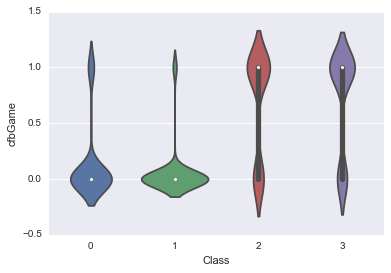

In [381]:
sns.violinplot('Class','cfbGame', data=Final2)

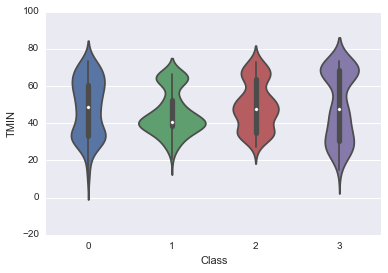

In [382]:
sns.violinplot('Class','TMIN', data=Final2)

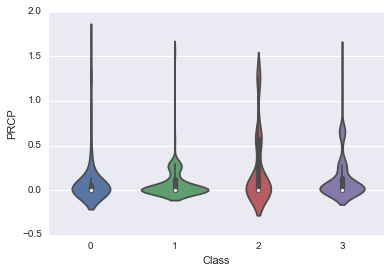

In [383]:
sns.violinplot('Class','PRCP', data=Final2)

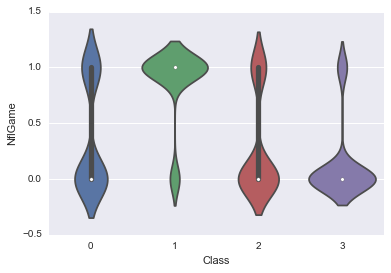

In [384]:
sns.violinplot('Class','NflGame', data=Final2)

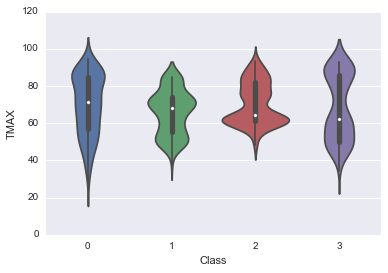

In [385]:
sns.violinplot('Class','TMAX', data=Final2)

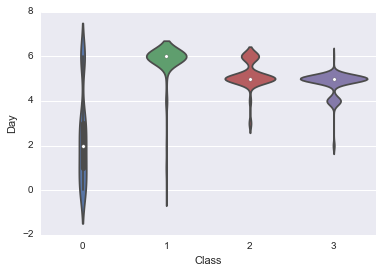

In [386]:
sns.violinplot('Class','Day', data=Final2)

These violin plots show the data in a different manner and allow us to see what the features are like when we see most of our high online_sales days. These plots indicate that sometimes there is an increase in high sales days when it rains more than 0.5 inches in a day. Also we can see that almost all high sales days occur on Saturdays. High sales also occur more often when the minimum temperature is between 80-100 and 40-60 degrees. These plots help, by showing us some possible thresholds for predicting high sales. 

### Using classifier to predict 2014

In [387]:
y1=Final2['Class']
X1=Final2.drop(Final2.ix[:,10:], axis=1)
X1['Day']=Final2['Day']

In [388]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.30, random_state=20)

In [389]:
# #Grid search cv for parameters
# rfc1 = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=100, oob_score = True) 

# param_grid1 = { 
#     'n_estimators': [100,200,300,400,500],
#     'criterion': ["gini"],
#     'max_features': [None, 'sqrt', 'log2'],
#     'min_samples_split':[1,2,3,4,5,6]
# }

# CV_rfc1 = GridSearchCV(estimator=rfc1, param_grid=param_grid1, cv= 5)
# CV_rfc1.fit(X_train1, y_train1)
# print CV_rfc1.best_params_
# print CV_rfc1.best_estimator_

In [390]:
cv_class = KFold(len(y_train1), shuffle=False) 
print cv_class
rfclass = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=5, verbose=0, warm_start=False)
rfclassScore = cross_val_score(rfclass, X_train1, y_train1, cv=cv_class,n_jobs=1)
print "Random forest classifier scores are:", rfclassScore
print "Regular forest classifier average score is:", rfclassScore.mean()

sklearn.cross_validation.KFold(n=491, n_folds=3, shuffle=False, random_state=None)
Random forest classifier scores are: [ 0.90853659  0.90853659  0.95092025]
Regular forest classifier average score is: 0.922664472043


In [391]:
rfclass.fit(X_train1, y_train1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=5, verbose=0, warm_start=False)

In [392]:
all(rfclass.feature_importances_ == np.mean([tree.feature_importances_ for tree in rfclass.estimators_], axis=0))

importancesClass = rfclass.feature_importances_
stdClass = np.std([tree.feature_importances_ for tree in rfclass.estimators_], axis=0)
indicesClass = np.argsort(importancesClass)[::-1]
feature_namesClass = X_train1.columns

(array([-0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ]),
 <a list of 10 Text yticklabel objects>)

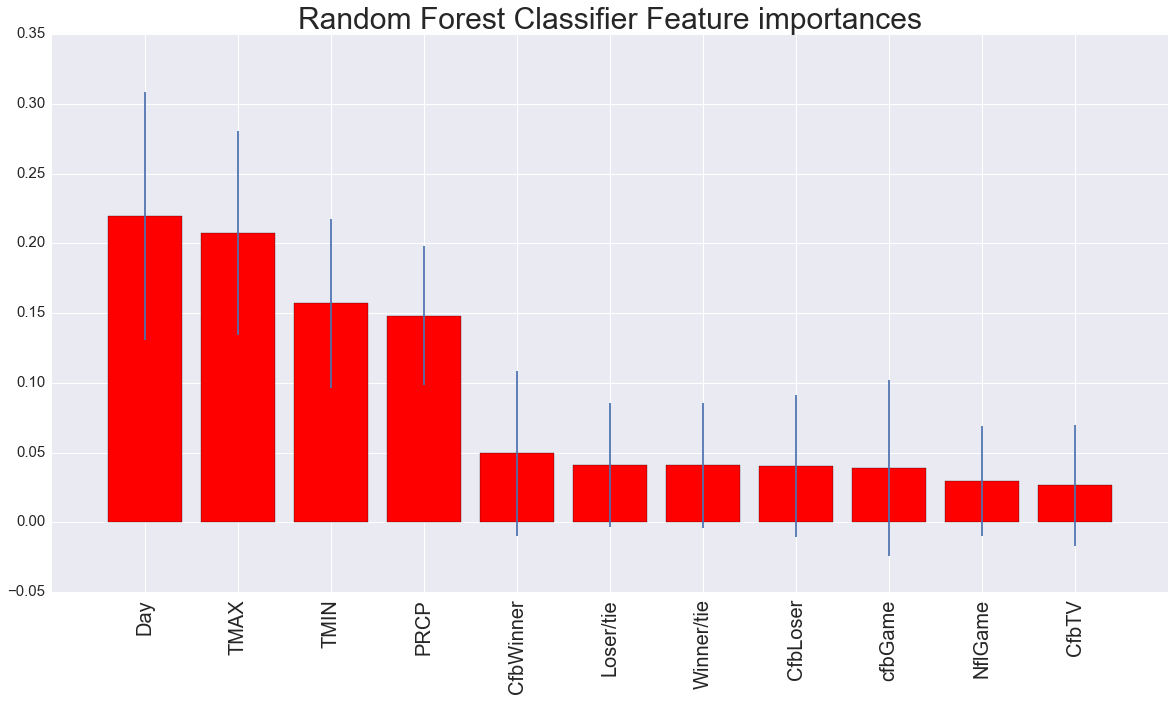

In [393]:
plt.figure(figsize=(20,10))
plt.title("Random Forest Classifier Feature importances", fontsize = 30)
plt.bar(range(X_train1.shape[1]), importancesClass[indicesClass],
       color="r", yerr=stdClass[indicesClass], align="center")
plt.xticks(range(X_train1.shape[1]), feature_names[indicesClass], rotation=90, fontsize = 20)
plt.xlim([-1, X_train1.shape[1]])
plt.yticks(fontsize=15)

We can see that precipitation is a more important feature in the classifier model vs. the regression model. It is also interesting that who the winner or loser of a football game is matters more than only whether there is a game or not. Weather and day of the week seem to be the mest predictors of whether a particular day will be a high sales day. These could be useful metrics to use to predict conversions of future data. 

In [394]:
Class_pred = rfclass.predict(X_test1)
Class_predict = pd.DataFrame()
Class_predict['actual'] = y_test1
Class_predict['predict'] = Class_pred
Class_probs = rfclass.predict_proba(X_test)
Class_predict['ProbBottom'],Class_predict['ProbMidLow'],Class_predict['ProbMidHi'],Class_predict['ProbHi'] = zip(*Class_probs)

In [395]:
Class_predict.head()

,actual,predict,ProbBottom,ProbMidLow,ProbMidHi,ProbHi
Date,,,,,,
2014-09-27,3,3,0.012000,0.000000,0.297917,0.690083
2014-10-19,1,1,0.007500,0.990000,0.000000,0.002500
2015-01-03,3,3,0.022500,0.010000,0.095667,0.871833
2014-11-16,1,1,0.042619,0.944048,0.003333,0.010000
2014-08-11,0,0,0.956667,0.006667,0.020000,0.016667


In [396]:
conf_mat = pd.crosstab(Class_predict['actual'], Class_predict['predict'], rownames=['actual'])
conf_mat

predict,0,1,2,3
actual,,,,
0,59,1,2,1
1,0,44,2,1
2,0,1,40,0
3,0,0,8,52


In [397]:
precision, recall, fscore, support = score(y_test1, Class_pred)

Scores=pd.DataFrame()
Scores['Class'] = ['Low','LowMed','HiMed','Hi']
Scores['precision'] = precision
Scores['recall'] = recall
Scores['fscore'] = fscore
Scores['support'] = support
Scores.head()

,Class,precision,recall,fscore,support
0,Low,1.000000,0.936508,0.967213,63
1,LowMed,0.956522,0.936170,0.946237,47
2,HiMed,0.769231,0.975610,0.860215,41
3,Hi,0.962963,0.866667,0.912281,60


In [402]:
classes=[0,1,2,3]
y_testBi = label_binarize(y_test1, classes)
y_predBi = label_binarize(Class_pred, classes)

In [403]:
print Class_pred

[3 1 3 1 0 1 0 2 2 2 1 0 1 1 3 1 0 2 0 0 0 3 0 0 3 2 2 2 1 0 3 1 0 0 1 2 1
 1 2 2 0 3 1 3 2 3 1 2 0 0 3 3 0 2 3 3 0 1 2 0 2 0 0 3 1 3 0 3 0 2 2 2 0 1
 3 1 2 1 3 2 3 2 2 0 2 1 0 2 0 0 3 3 0 3 0 1 0 1 1 2 2 2 2 2 2 1 3 2 2 0 3
 3 1 3 3 2 1 2 0 2 3 0 3 0 3 3 0 0 1 1 0 3 0 1 1 1 1 0 3 2 3 3 0 0 2 0 0 0
 3 0 0 2 0 1 1 0 3 3 3 1 1 3 3 3 2 0 3 3 2 3 2 1 2 1 0 1 2 0 0 1 1 3 2 2 1
 3 1 3 0 0 0 2 3 0 1 1 0 0 2 2 2 2 0 3 1 3 3 3 3 2 2]


In [404]:
n_classes=len(classes)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_testBi[:,i], y_predBi[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

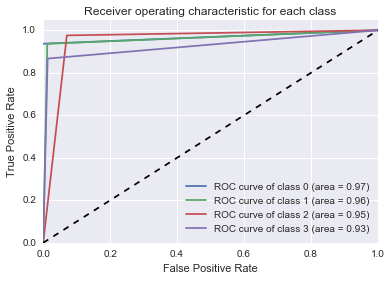

In [405]:
# Plot all ROC curves
plt.figure()


for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for each class')
plt.legend(loc="lower right")
plt.show()


In [406]:

Class15 = Test.drop(Test.ix[:,10:], axis=1)
X3=Final2.drop(Final2.ix[:,10:], axis=1)
y3=Final2['Class']
X3['Day']=Final2['Day']
Class15['Day']=Test['Day']

In [407]:
rfclass.fit(X3,y3)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=5, verbose=0, warm_start=False)

In [408]:
Class15_pred = rfclass.predict(Class15)
Class15_predict = pd.DataFrame()
Class15_predict['actual'] = Test['Class']
Class15_predict['predict'] = Class15_pred
Class15_probs = rfclass.predict_proba(Class15)
Class15_predict['ProbBottom'],Class15_predict['ProbMidLow'],Class15_predict['ProbMidHi'],Class15_predict['ProbHi'] = zip(*Class15_probs)

In [409]:
Class15_predict.head()

,actual,predict,ProbBottom,ProbMidLow,ProbMidHi,ProbHi
Date,,,,,,
2015-08-01,2,3,0.177190,0.077357,0.255857,0.489595
2015-08-02,0,0,0.643690,0.016167,0.181667,0.158476
2015-08-03,0,0,0.909167,0.000000,0.034167,0.056667
2015-08-04,0,0,0.947500,0.000000,0.017500,0.035000
2015-08-05,0,0,0.889167,0.000000,0.054167,0.056667


In [411]:
conf_mat = pd.crosstab(Class15_predict['actual'], Class15_predict['predict'], rownames=['actual'])
conf_mat

predict,0,1,2,3
actual,,,,
0,87,0,0,1
1,42,137,0,0
2,4,24,16,5
3,3,0,189,69


In [412]:
precision15, recall15, fscore15, support15 = score(Class15_predict['actual'], Class15_pred)

Scores15=pd.DataFrame()
Scores15['Class'] = ['Low','LowMed','HiMed','Hi']
Scores15['precision'] = precision15
Scores15['recall'] = recall15
Scores15['fscore'] = fscore15
Scores15['support'] = support15
Scores15.head()

,Class,precision,recall,fscore,support
0,Low,0.639706,0.988636,0.776786,88
1,LowMed,0.850932,0.765363,0.805882,179
2,HiMed,0.078049,0.326531,0.125984,49
3,Hi,0.920000,0.264368,0.410714,261


In [413]:
#use threshold to try to improve model, try regular decision tree

In [414]:
#write summary of this crappy model

In [415]:
y_testBi1 = label_binarize(Test['Class'], classes)
y_predBi1 = label_binarize(Class15_pred, classes)

In [416]:
n_classes=y_testBi1.shape[1]
fpr1 = dict()
tpr1 = dict()
roc_auc1 = dict()
for i in range(n_classes):
    fpr1[i], tpr1[i], _ = roc_curve(y_testBi1[:,i], y_predBi1[:,i])
    roc_auc1[i] = auc(fpr1[i], tpr1[i])

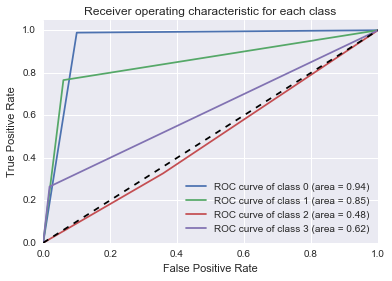

In [417]:
plt.figure()


for i in range(n_classes):
    plt.plot(fpr1[i], tpr1[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc1[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for each class')
plt.legend(loc="lower right")
plt.show()


This model is not good for predicting classes in the upper two quartiles of sales. However, almost all of the mis-classified points for the class 2 and 3 predictions were in the upper two quartiles. Perhaps we could use a more simple classification method and just classify days as high or low selling days.  

In [418]:
def binaryConversions(cl):
    if cl > 1990: 
        return 1
    else:
        return 0

In [419]:
Test['BiClass'] = Test['online_sales'].map(binaryConversions)

/Users/AlexStrahan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [420]:
Final2['BiClass'] = Final2['online_sales'].map(binaryConversions)

/Users/AlexStrahan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [421]:
Class15Bi = Test.drop(Test.ix[:,10:], axis=1)
X4=Final2.drop(Final2.ix[:,10:], axis=1)
y4=Final2['BiClass']
X4['Day']=Final2['Day']
Class15Bi['Day']=Test['Day']

In [422]:
cv_classBi = KFold(len(y4), shuffle=False) 
print cv_classBi
rfclassBi = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=5, verbose=0, warm_start=False)
rfclassBiScore = cross_val_score(rfclassBi, X4, y4, cv=cv_class,n_jobs=1)
print "Random forest classifier scores are:", rfclassBiScore
print "Regular forest classifier average score is:", rfclassBiScore.mean()

sklearn.cross_validation.KFold(n=702, n_folds=3, shuffle=False, random_state=None)
Random forest classifier scores are: [ 0.84146341  0.98170732  0.89570552]
Regular forest classifier average score is: 0.906292084393


In [423]:
rfclassBi.fit(X4,y4)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=5, verbose=0, warm_start=False)

In [424]:
Class15Bi_pred = rfclassBi.predict(Class15Bi)
Class15Bi_predict = pd.DataFrame()
Class15Bi_predict['actual'] = Test['BiClass']
Class15Bi_predict['predict'] = Class15Bi_pred
Class15Bi_probs = rfclassBi.predict_proba(Class15Bi)

In [425]:
conf_mat = pd.crosstab(Class15Bi_predict['actual'], Class15Bi_predict['predict'], rownames=['actual'])
conf_mat

predict,0,1
actual,,
0,262,5
1,39,271


In [426]:
Final2.to_csv('../Assets/2014data.csv')

In [427]:
Test.to_csv('../Assets/2015data.csv')

In [428]:
frames = [Final2, Test]
Tableau = pd.concat(frames)

In [429]:
Tableau.to_csv('../Assets/TableauData.csv')

### Decision Tree Binary Classifier

In [430]:
#Grid search cv for parameters
DTBinary = DecisionTreeClassifier(max_features= 'sqrt' ) 

param_grid1 = { 
    'criterion': ["gini"],
    'max_features': [None, 'sqrt', 'log2'],
    'min_samples_split':[1,2,3,4,5,6]
}

CV_DT = GridSearchCV(estimator=DTBinary, param_grid=param_grid1, cv= 5)
CV_DT.fit(X4, y4)
print CV_DT.best_params_
print CV_DT.best_estimator_

{'max_features': 'log2', 'min_samples_split': 1, 'criterion': 'gini'}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='log2', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=1, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')


In [431]:
cv_classDT = KFold(len(y4), shuffle=False) 
print cv_classDT
DTBinary = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='log2', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=1, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
DTBinaryScore = cross_val_score(DTBinary, X4, y4, cv=cv_class,)
print "Decision Tree classifier scores are:", DTBinaryScore
print "Decision Tree classifier average score is:", DTBinaryScore.mean()

sklearn.cross_validation.KFold(n=702, n_folds=3, shuffle=False, random_state=None)
Decision Tree classifier scores are: [ 0.8597561   0.89634146  0.85889571]
Decision Tree classifier average score is: 0.871664422166


In [432]:
DTBinary.fit(X4,y4)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='log2', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=1, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [433]:
DTBinary_pred = rfclassBi.predict(Class15Bi)
DTBinary_predict = pd.DataFrame()
DTBinary_predict['actual'] = Test['BiClass']
DTBinary_predict['predict'] = DTBinary_pred
DTBinary_probs = rfclassBi.predict_proba(Class15Bi)

In [434]:
conf_mat = pd.crosstab(DTBinary_predict['actual'], DTBinary_predict['predict'], rownames=['actual'])
conf_mat

predict,0,1
actual,,
0,262,5
1,39,271


The Decision tree model is just as good as the random forest at predicting the 

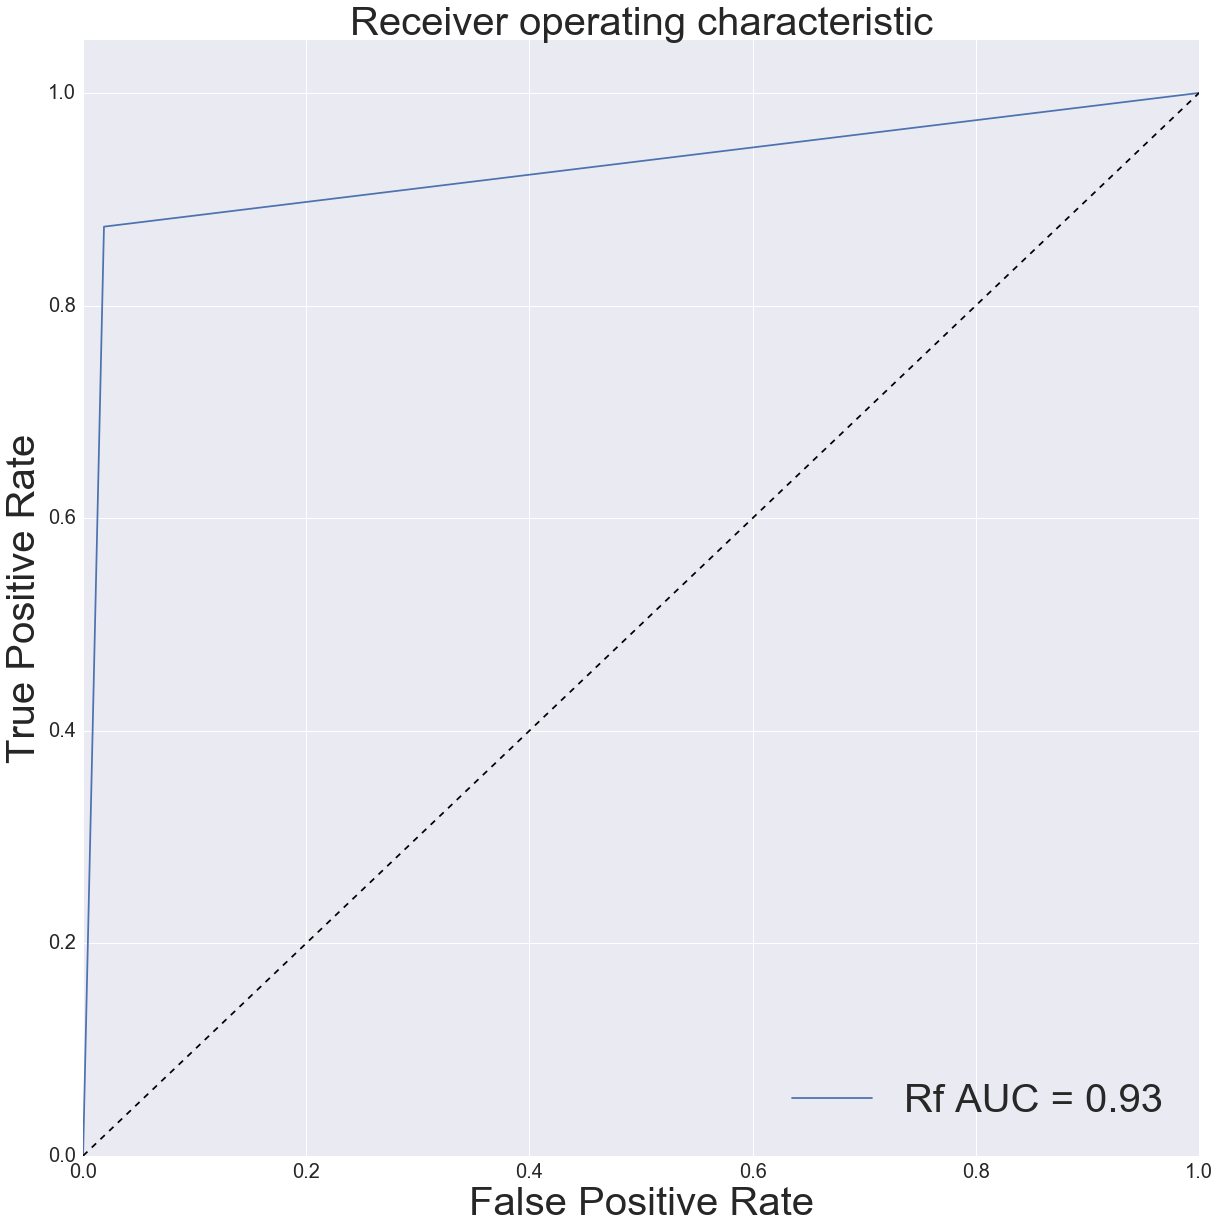

In [439]:
Bifpr = dict()
Bitpr = dict()
Biroc_auc = dict()
Bifpr, Bitpr, _ = roc_curve(DTBinary_predict.actual, DTBinary_predict.predict)
Biroc_auc = auc(Bifpr, Bitpr)

# Plot of a ROC curve 
plt.figure(figsize=(20,20))
plt.plot(Bifpr, Bitpr, label='Rf AUC = %0.2f' % Biroc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=40)
plt.ylabel('True Positive Rate', fontsize=40)
plt.title('Receiver operating characteristic', fontsize=40)
plt.legend(loc="lower right", fontsize=40)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.show()

In [435]:
export_graphviz(DTBinary.fit(X4,y4), out_file='tree.dot', feature_names=X4.columns)                

In [436]:
#converting exported dot file to png file using bash
! dot -Tpng tree.dot -o tree.png

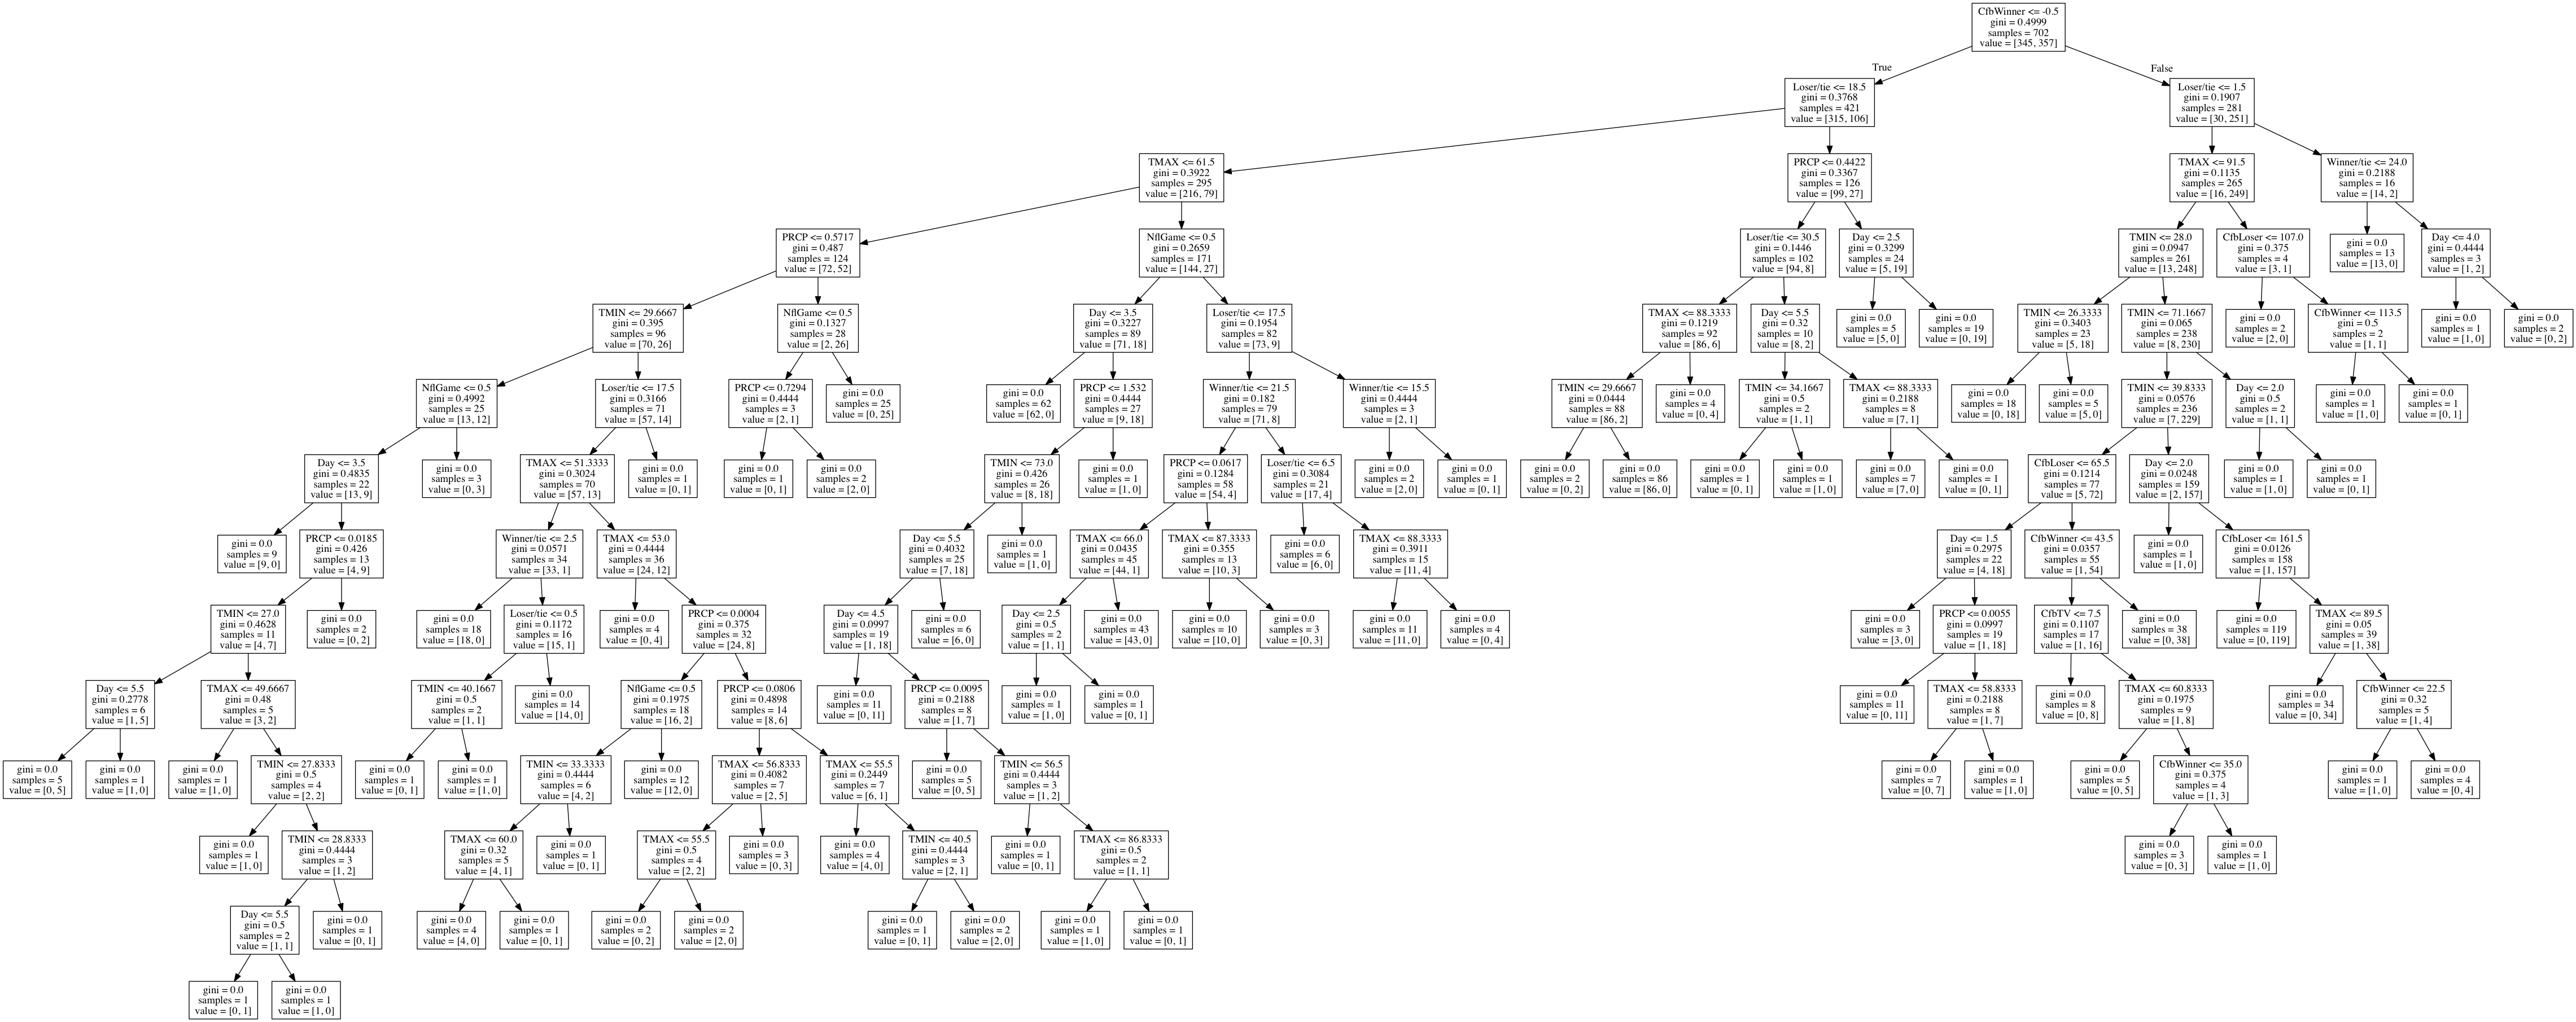

In [437]:
from IPython.display import Image
Image(filename='tree.png') 

### Recommendations and limitations

We can use this model to predict whether a day will be a high or low sales day. We can then use this to decide where to spend our advertising budget. We can even look through the actual decision tree to make decisions based on the categorization of the features that we know.

One major limitation is that we did not treat this as time series data. We can also play with thresholds for deciding whether or not a day will be a high or low sales day.